In [1]:
from optimpv import *
from optimpv.axBOtorch.axUtils import *
import pandas as pd
import numpy as np
from scipy import interpolate
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

mun = FitParam(name = 'l2.mu_n', value = 3e-4, bounds = [1e-4,1e-3], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_n$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None)

mup = FitParam(name = 'l2.mu_p', value = 8e-4, bounds = [1e-4,1e-3], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_p$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None)



params = [mun, mup]



(153, 2)
(153,)


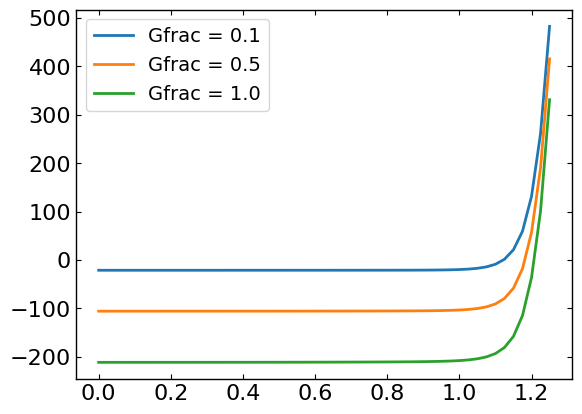

In [2]:
import pySIMsalabim as sim
from pySIMsalabim.experiments.JV_steady_state import *

session_path = os.path.join('/home/lecorre/Desktop/pySIMsalabim/', 'SIMsalabim','SimSS')
simss_device_parameters = os.path.join(session_path, 'simulation_setup.txt')

# Set the JV parameters
Gfracs = [0.1,0.5,1.0] # Fractions of the generation rate to simulate
# Gfracs = None
UUID = str(uuid.uuid4())

cmd_pars = []
for param in params:
    cmd_pars.append({'par':param.name, 'val':str(param.value)})

# Run the JV simulation
ret, mess = run_SS_JV(simss_device_parameters, session_path, JV_file_name = 'JV.dat', varFile= 'Var.dat',G_fracs = Gfracs, parallel = False, max_jobs = 3, UUID=UUID, cmd_pars=cmd_pars)


# save data for fitting
X,y = [],[]
if Gfracs is None:
    data = pd.read_csv(os.path.join(session_path, 'JV_'+UUID+'.dat'), sep=r'\s+') # Load the data
    Vext = np.asarray(data['Vext'].values)
    Jext = np.asarray(data['Jext'].values)
    G = np.ones_like(Vext)

    X= Vext
    y = Jext

    plt.figure()
    plt.plot(X,y)
    plt.show()
else:
    for Gfrac in Gfracs:
        data = pd.read_csv(os.path.join(session_path, 'JV_Gfrac_'+str(Gfrac)+'_'+UUID+'.dat'), sep=r'\s+') # Load the data
        Vext = np.asarray(data['Vext'].values)
        Jext = np.asarray(data['Jext'].values)
        G = np.ones_like(Vext)*Gfrac

        if len(X) == 0:
            X = np.vstack((Vext,G)).T
            y = Jext
        else:
            X = np.vstack((X,np.vstack((Vext,G)).T))
            y = np.hstack((y,Jext))

    print(X.shape)
    print(y.shape)


    plt.figure()
    for Gfrac in Gfracs:
        plt.plot(X[X[:,1]==Gfrac,0],y[X[:,1]==Gfrac],label='Gfrac = '+str(Gfrac))
    plt.legend()
    plt.show()




In [3]:
from optimpv.DDfits.FitstabJV import JV_SS_agent
metric = 'mse'
loss = 'linear'

jv = JV_SS_agent(params, X, y, session_path, simss_device_parameters,parallel = False, max_jobs = 3, metric = metric, loss = loss)

In [4]:
# jv.run(parameters={mun.name: 3e-4, mup.name: 6e-4})
# jv.run_Ax(parameters={mun.name: 5e-4, mup.name: 5e-4})
jv.run_scikit(parameters= [5e-4, 5e-4])

{'l2.mu_n': 0.0005, 'l2.mu_p': 0.0005}


2.3073809596106014

In [6]:
mu = np.geomspace(1e-4,1e-3,10)
MSE = np.zeros((len(mu),len(mu)))
for i, m in enumerate(mu):
    for j,n in enumerate(mu):
        
        MSE[i,j] = jv.run_scikit(parameters= [m, n])



{'l2.mu_n': 0.0001, 'l2.mu_p': 0.0001}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.00012915496650148838}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.0001668100537200059}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.00021544346900318845}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.0002782559402207126}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.00035938136638046257}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.00046415888336127773}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.0005994842503189409}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.000774263682681127}
{'l2.mu_n': 0.0001, 'l2.mu_p': 0.001}
{'l2.mu_n': 0.00012915496650148838, 'l2.mu_p': 0.0001}
{'l2.mu_n': 0.00012915496650148838, 'l2.mu_p': 0.00012915496650148838}
{'l2.mu_n': 0.00012915496650148838, 'l2.mu_p': 0.0001668100537200059}
{'l2.mu_n': 0.00012915496650148838, 'l2.mu_p': 0.00021544346900318845}
{'l2.mu_n': 0.00012915496650148838, 'l2.mu_p': 0.0002782559402207126}
{'l2.mu_n': 0.00012915496650148838, 'l2.mu_p': 0.00035938136638046257}
{'l2.mu_n': 0.00012915496650148838, 'l2.mu_p': 0.00046415888336127773}
{'l2.mu_n

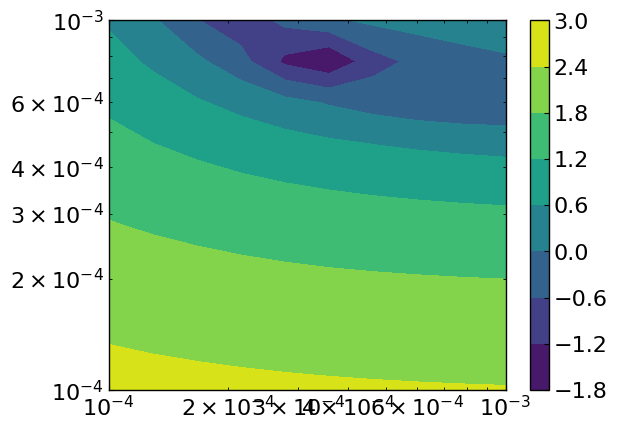

In [10]:
plt.figure()
plt.contourf(mu,mu,np.log10(MSE).T)
plt.colorbar()
# set log scale
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# Clean up the output files (comment out if you want to keep the output files)
sim.clean_all_output(session_path)
sim.delete_folders('tmp',session_path)